In [5]:
import numpy as np
from numpy.random import default_rng
import matplotlib.pyplot as plt
import networkx as nx
import random
from skimage.util import view_as_blocks
import queue
from tqdm.notebook import tqdm
from time import sleep
import math
import random

In [17]:
N_PROBES = 1000
N_ITERATIONS = 1000
PATCH_SIZE = [64,64]
STOCHASTIC_SAMPLING = 0

sense_distance = 1.0
sense_angle = 2.5
step_size = 0.1
steering_rate = 0.5

In [18]:
TRACE_PATH = 'trace.npy'

print('Number of probes:', N_PROBES)
print('Patch Size:', PATCH_SIZE)

Number of probes: 1000
Patch Size: [64, 64]


In [21]:
def probe_propogation(TRACE_PATH, N_ITERATIONS, N_PROBES, STOCHASTIC_SAMPLING, PATCH_SIZE, sense_distance, sense_angle, step_size, steering_rate):
    TRACE = np.load(TRACE_PATH)
    G = nx.DiGraph()
    patch = np.copy(TRACE[0:PATCH_SIZE[0],0:PATCH_SIZE[1],:])
    DOMAIN_SIZE = [PATCH_SIZE[0]-1,PATCH_SIZE[1]-1]
    
    probe_field = np.zeros((N_PROBES, 4))
    probe_field[:, 0] = default_rng().uniform(low=0.0, high=DOMAIN_SIZE[0], size=probe_field.shape[0])
    probe_field[:, 1] = default_rng().uniform(low=0.0, high=DOMAIN_SIZE[1], size=probe_field.shape[0])
    probe_field[:, 2] = default_rng().uniform(low=0.0, high=2.0*np.pi, size=probe_field.shape[0])
    probe_field[:, 3] = 1.0
    
    angle_queue = queue.Queue(maxsize=3)
    pos_dict = {}
    flag = 0
    last = 0
    second_last = 0
    past_pos = []

    
    def world_to_grid_2D(pos_world, size_world, size_grid):
        return (pos_world / size_world) * (size_grid)

    def angle_to_dir_2D(angle):
        return np.array([math.cos(float(angle)), math.sin(float(angle))])

    def custom_mod(a, b):
        return (a - b * math.floor(a / b))
    
    def nodes_connected(u, v):
        return u in G.neighbors(v)
    
    def distance(pos1, pos2):
        return math.sqrt((pos1[0] - pos2[0])**2 + (pos1[1] - pos2[1])**2)

    for i in tqdm(range(N_ITERATIONS)):
        for probe in range(probe_field.shape[0]):
            pos1, pos2, angle, weight = probe_field[probe]
            pos = [pos1, pos2]
            dir_fwd = angle_to_dir_2D(angle)
            angle_mut = angle + (random.random() - 0.5) * sense_angle
            dir_mut = angle_to_dir_2D(angle_mut)

            t_fwd = world_to_grid_2D(pos + sense_distance * dir_fwd, np.array(DOMAIN_SIZE), np.array(DOMAIN_SIZE))
            t_mut = world_to_grid_2D(pos + sense_distance * dir_mut, np.array(DOMAIN_SIZE), np.array(DOMAIN_SIZE))
            trace_fwd = (patch[t_fwd[0].astype(int)][t_fwd[1].astype(int)][0])
            trace_mut = (patch[t_mut[0].astype(int)][t_mut[1].astype(int)][0])

            angle_new = 0.0
            
            if (trace_fwd > trace_mut):
                angle_new = (angle)
            else:
                angle_new = (steering_rate * angle_mut + (1.0-steering_rate) * angle)     


            if(G.number_of_nodes() == 0):
                G.add_node(probe, position=(pos1, pos2))
                angle_queue.put(angle_new)
                last = probe
            else:
                second_last = last
                last = probe

                if abs(angle_new - angle_queue.queue[0]) > 0.10:
                    second_last = last
                    last = probe

                    G.add_node(probe, position=(pos1, pos2))
                    G.add_edge(last, second_last, length=distance(past_pos, pos))
                    
                    if(angle_queue.qsize() == 3):
                        angle_queue.get()
                    angle_queue.put(angle_new)

            dir_new = angle_to_dir_2D(angle_new)   

            past_pos = [pos1, pos2]
            pos_new = pos + step_size * dir_new

            pos_new[0] = custom_mod(pos_new[0], DOMAIN_SIZE[0])
            pos_new[1] = custom_mod(pos_new[1], DOMAIN_SIZE[1])

            probe_field[probe][0] = pos_new[0]
            probe_field[probe][1] = pos_new[1]
            probe_field[probe][2] = angle_new

            flag = flag + 1
        
    patch_underlay = np.rot90(patch[:,:,0])
    patch_underlay = np.flipud(patch_underlay)
    
    
    for k in list(G.edges):
        if(G[k[0]][k[1]]['length'] > 1.5):
            G.remove_edge(k[0], k[1])
    
    remove = [position[0] for position in G.nodes.data("position") if position[1] == None]
    G.remove_nodes_from(remove)
      
    return G, patch_underlay, dict(G.nodes.data("position"))

In [22]:
graph, patch, positions = probe_propogation(TRACE_PATH, N_ITERATIONS, N_PROBES, STOCHASTIC_SAMPLING, PATCH_SIZE, sense_distance, sense_angle, step_size, steering_rate)

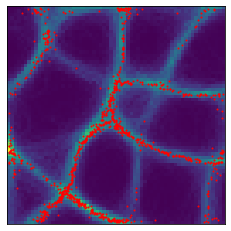

In [23]:
plt.imshow(patch)
nx.draw_networkx_nodes(graph, pos=positions,
        node_size=1.0, 
        node_color='red')
plt.savefig("out_1_v1.png", dpi=1000)

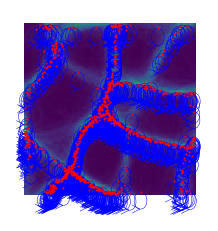

In [24]:
plt.imshow(patch)
nx.draw(graph, pos=positions,
        arrowstyle='->',
        arrowsize=20,
        width=0.5,
        with_labels=False, 
        node_size=1.0,
        node_color='red',
        edge_color='blue')
plt.savefig("out_2_v1.png", dpi=1000)